In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import sympy 
from sympy import banded, ones, Matrix, symbols, sqrt
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import pickle
import scipy

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [4]:
Nv = 3

In [5]:
v, zeta = symbols('v \zeta') 

In [6]:
def legendre(xi, n):
    if n<0:
        return 0
    elif n==0:
        return 1
    elif n==1:
        return xi
    else:
        return ((2*n-1)*xi*legendre(xi=xi, n=n-1) - (n-1)*legendre(xi=xi, n=n-2))/n

In [7]:
vb = 5
va = -5

In [8]:
vec_mu = sympy.zeros(Nv)

for ii in range(0, Nv):
    beta = sympy.sqrt(2*ii + 1) * legendre(xi=(2*v -(vb+va))/(vb-va), n=ii)
    vec_mu[ii] = sympy.integrate(beta*sympy.exp(-(v**2)/2)*v, (v, va, vb))/(sympy.sqrt(sympy.pi)*2)

In [9]:
sympy.simplify(vec_mu[0, :])

Matrix([[0, -sqrt(3)*exp(-25/2)/sqrt(pi) + sqrt(6)*erf(5*sqrt(2)/2)/10, 0]])

In [10]:
vec_off = sympy.zeros(Nv)
vec_main = sympy.zeros(Nv)
for jj in range(1, Nv+1):
    vec_off[jj-1] = (sympy.Rational(vb - va, 2) * (jj/sympy.sqrt((2*jj+1)*(2*jj-1)))) / sympy.sqrt(2)
    vec_main[jj-1] = sympy.Rational(va + vb, 2) / sympy.sqrt(2)

In [11]:
vec_off[0, :]

Matrix([[5*sqrt(6)/6, sqrt(30)/3, 3*sqrt(70)/14]])

In [12]:
vec_main[0, :]

Matrix([[0, 0, 0]])

In [13]:
A = banded({1: tuple(vec_off[0, :-1]), -1: tuple(vec_off[0, :-1]), 0:tuple(vec_main[0, :])})

In [14]:
A

Matrix([
[          0, 5*sqrt(6)/6,          0],
[5*sqrt(6)/6,           0, sqrt(30)/3],
[          0,  sqrt(30)/3,          0]])

In [15]:
I = np.eye(Nv)

In [16]:
M = sympy.Matrix(I*zeta - A)

In [17]:
result = sympy.simplify((M.inv().multiply(vec_mu[0, :].T))[0])
result

(-4.16666666666667*sqrt(2) + 0.833333333333333*sqrt(pi)*exp(25/2)*erf(5*sqrt(2)/2))*exp(-25/2)/(sqrt(pi)*(1.66666666666667*\zeta**2 - 12.5))

In [18]:
with open("legendre_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(result, outf)

# Kinetic response function 

In [19]:
def Z_fun(z):
    return 1j*np.sqrt(np.pi)*wofz(z)

def R(xi):
    return -(1 + xi*Z_fun(xi))

def RHP3(xi):
    xi = xi*np.sqrt(2)
    return (-1j*xi + 1.596)/(-1j*(xi**3) + 1.596*(xi**2) + 3*1j*xi -1.596)

def RHP4(xi):
    xi = xi*np.sqrt(2)
    return (xi**2 + 3.519*1j*xi -5.615)/(xi**4 + 3.519*1j*(xi**3) -8.615*(xi**2) -10.556*1j*xi + 5.615)

def R3(xi):
    with open('legendre_3.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

def R4(xi):
    with open('legendre_4.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

def R5(xi):
    with open('legendre_5.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

def R10(xi):
    with open('legendre_10.txt','rb') as f:
        return sympy.lambdify(zeta, pickle.load(f))(xi)

In [20]:
xi = 10**np.linspace(-2, 2, int(1e3))

In [21]:
R_3 = R3(xi)
R_HP3 = RHP3(xi)
R_HP4 = RHP4(xi)
R_4 = R4(xi)
R_5 = R5(xi)
R_10 = R10(xi)
R_true = R(xi)

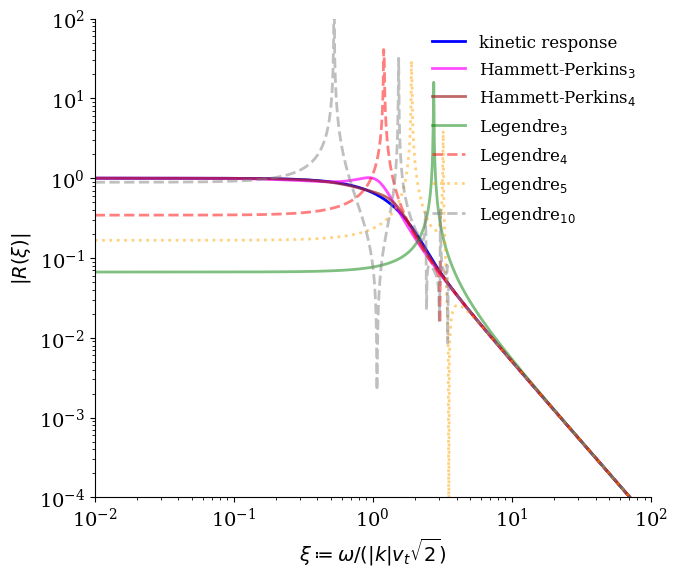

In [22]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(xi, np.abs(R_true), label=r"kinetic response", c="blue", linewidth=2)
ax.plot(xi, np.abs(R_HP3), label=r"Hammett-Perkins$_{3}$", c="magenta", linewidth=2, alpha=0.7)
ax.plot(xi, np.abs(R_HP4), label=r"Hammett-Perkins$_{4}$", c="brown", linewidth=2, alpha=0.7)
ax.plot(xi, np.abs(R_3), label=r"Legendre$_{3}$", c="green", ls="-", linewidth=2, alpha=0.5)
ax.plot(xi, np.abs(R_4), label=r"Legendre$_{4}$", c="red", ls="--", linewidth=2, alpha=0.5)
ax.plot(xi, np.abs(R_5), label=r"Legendre$_{5}$", c="orange", ls=":", linewidth=2, alpha=0.5)
ax.plot(xi, np.abs(R_10), label=r"Legendre$_{10}$", c="grey", ls="--", linewidth=2, alpha=0.5)
ax.set_ylim(10**-4, 10**2)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|R(\xi)|$")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/symbolic_response_function_SPS_Legendre.png", dpi=600)

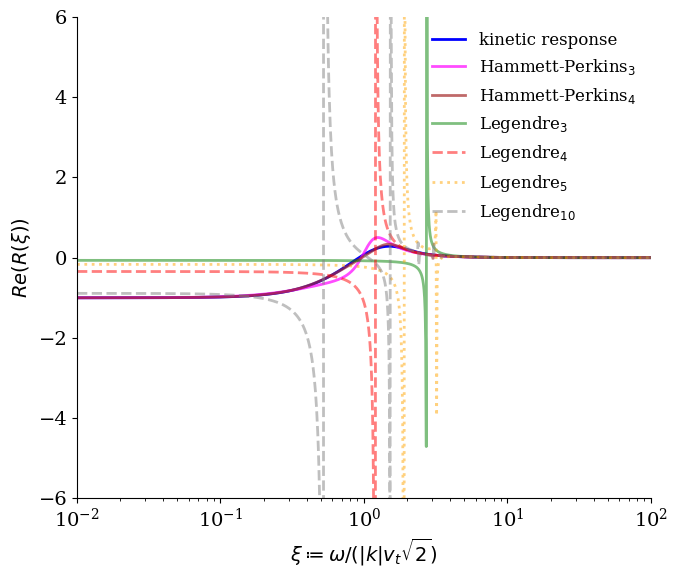

In [23]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(xi, np.real(R_true), label=r"kinetic response", c="blue", linewidth=2)
ax.plot(xi, np.real(R_HP3), label=r"Hammett-Perkins$_{3}$", c="magenta", linewidth=2, alpha=0.7)
ax.plot(xi, np.real(R_HP4), label=r"Hammett-Perkins$_{4}$", c="brown", linewidth=2, alpha=0.7)
ax.plot(xi, np.real(R_3), label=r"Legendre$_{3}$", c="green", ls="-", linewidth=2, alpha=0.5)
ax.plot(xi, np.real(R_4), label=r"Legendre$_{4}$", c="red", ls="--", linewidth=2, alpha=0.5)
ax.plot(xi, np.real(R_5), label=r"Legendre$_{5}$", c="orange", ls=":", linewidth=2, alpha=0.5)
ax.plot(xi, np.real(R_10), label=r"Legendre$_{10}$", c="grey", ls="--", linewidth=2, alpha=0.5)

ax.set_ylim(-6, 6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$Re(R(\xi))$")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()

plt.savefig("../figs/symbolic_response_function_SPS_real_Legendre.png", dpi=600)

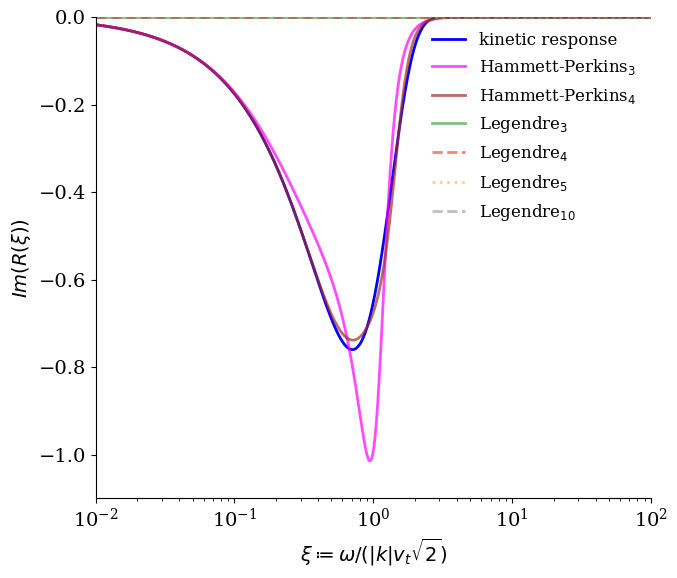

In [24]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(xi, np.imag(R_true), label=r"kinetic response", c="blue", linewidth=2)
ax.plot(xi, np.imag(R_HP3), label=r"Hammett-Perkins$_{3}$", c="magenta", linewidth=2, alpha=0.7)
ax.plot(xi, np.imag(R_HP4), label=r"Hammett-Perkins$_{4}$", c="brown", linewidth=2, alpha=0.7)
ax.plot(xi, np.imag(R_3), label=r"Legendre$_{3}$", c="green", ls="-", linewidth=2, alpha=0.5)
ax.plot(xi, np.imag(R_4), label=r"Legendre$_{4}$", c="red", ls="--", linewidth=2, alpha=0.5)
ax.plot(xi, np.imag(R_5), label=r"Legendre$_{5}$", c="orange", ls=":", linewidth=2, alpha=0.5)
ax.plot(xi, np.imag(R_10), label=r"Legendre$_{10}$", c="grey", ls="--", linewidth=2, alpha=0.5)

ax.set_ylim(-1.1, 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$Im(R(\xi))$")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()

plt.savefig("../figs/symbolic_response_function_SPS_imag_Legendre.png", dpi=600)

In [25]:
n,d = sympy.fraction(R10(zeta))
d

(1023348386493.44*\zeta**10 - 30296498284345.1*\zeta**8 + 311875717632965.0*\zeta**6 - 1.29948215680402e+15*\zeta**4 + 1.87425311077503e+15*\zeta**2 - 425966616085234.0)*(3.3334745640625e+23*\zeta**20 - 1.97376783398437e+25*\zeta**18 + 4.95351563598633e+26*\zeta**16 - 6.86184766845703e+27*\zeta**14 + 5.72454893875122e+28*\zeta**12 - 2.94434192848205e+29*\zeta**10 + 9.17856913805008e+29*\zeta**8 - 1.63509875535965e+30*\zeta**6 + 1.47055881097913e+30*\zeta**4 - 5.08257653564215e+29*\zeta**2 + 5.7756551541388e+28)

In [26]:
sympy.roots(d)

{-3.44356578079206: 1,
 -3.05806618608516: 1,
 -2.40217942829335: 1,
 -1.53232745416053: 1,
 -0.526352228115580: 1,
 0.526352228115580: 1,
 1.53232745416053: 1,
 2.40217942829335: 1,
 3.05806618608516: 1,
 3.44356578079206: 1,
 -3.44313643944959 - 0.000248336302793966*I: 1,
 -3.44313643944959 + 0.000248336302793966*I: 1,
 -3.05865820181207 - 0.000342180092243475*I: 1,
 -3.05865820181207 + 0.000342180092243475*I: 1,
 -2.40202363299316 - 8.98583261265258e-5*I: 1,
 -2.40202363299316 + 8.98583261265258e-5*I: 1,
 -1.53226243884908 - 3.75303239247368e-5*I: 1,
 -1.53226243884908 + 3.75303239247368e-5*I: 1,
 -0.526349295731531 - 1.69301762739486e-6*I: 1,
 -0.526349295731531 + 1.69301762739486e-6*I: 1,
 0.526349295731531 - 1.69301762739486e-6*I: 1,
 0.526349295731531 + 1.69301762739486e-6*I: 1,
 1.53226243884908 - 3.75303239247368e-5*I: 1,
 1.53226243884908 + 3.75303239247368e-5*I: 1,
 2.40202363299316 - 8.98583261265258e-5*I: 1,
 2.40202363299316 + 8.98583261265258e-5*I: 1,
 3.05865820181207 -

# Analytic Response function

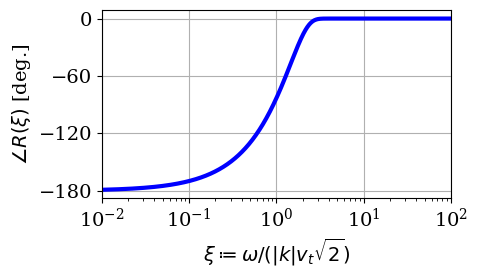

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(xi, np.angle(R_true, deg=True), linewidth=3, color="blue")
ax.set_xscale("log")
ax.set_ylabel(r"$\angle R(\xi)$ [deg.]")
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xlim(1e-2, 1e2)
ax.set_yticks([0, -60, -120, -180])
plt.grid()
plt.tight_layout()
plt.savefig("../figs/angle.png", dpi=600)

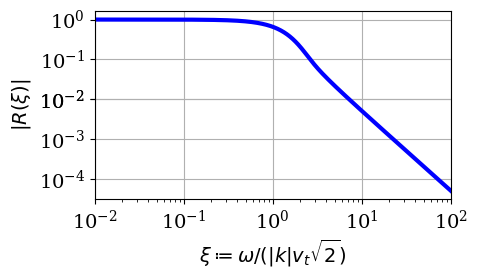

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(xi, np.abs(R_true), linewidth=3, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"$|R(\xi)|$")
ax.set_yticks([1, 1e-1, 1e-2, 1e-2, 1e-3, 1e-4])
ax.set_xlabel(r"$\xi \coloneq \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xlim(1e-2, 1e2)
plt.grid()
plt.tight_layout()
plt.savefig("../figs/magnitude.png", dpi=600)

# Landau Damping Dispersion Relation

In [29]:
def get_landau_dispersion(func, xi_real, xi_imag, tol=1e-5):
    # initialize vectors 
    k_ = np.zeros(len(xi_real))*np.nan
    gr_ = np.zeros(len(xi_real))*np.nan
    # loop over to find minima
    for ii, xr in enumerate(xi_real):
        r_ = func(xi=xr + 1j*xi_imag) 
        if np.min(np.abs(np.imag(r_))) < tol:
            gr_[ii] = xi_imag[np.nanargmin(np.abs(r_.imag))]
            if r_[np.nanargmin(np.abs(np.imag(r_)))].real>=0:
                k_[ii] = np.sqrt(r_[np.nanargmin(np.abs(r_.imag))].real)
    return gr_[np.argsort(k_)], k_[np.argsort(k_)]

In [30]:
gr_true, k_true = get_landau_dispersion(func=R, xi_real=np.linspace(0, 5, int(1e4)), xi_imag=np.linspace(-1, 0, int(1e4)))

In [31]:
gr_hp3, k_hp3 = get_landau_dispersion(func=RHP3, xi_real=np.linspace(0, 7, int(1e4)), xi_imag=np.linspace(-0.8, 0, int(1e4)))

In [32]:
gr_hp4, k_hp4 = get_landau_dispersion(func=RHP4, xi_real=np.linspace(0, 6, int(1e4)), xi_imag=np.linspace(-0.75, 0, int(1e4)))

In [33]:
gr_l10, k_l10 = get_landau_dispersion(func=R10, xi_real=np.linspace(0, 6, int(1e3)), xi_imag=np.linspace(-0.75, 0, int(1e3)))

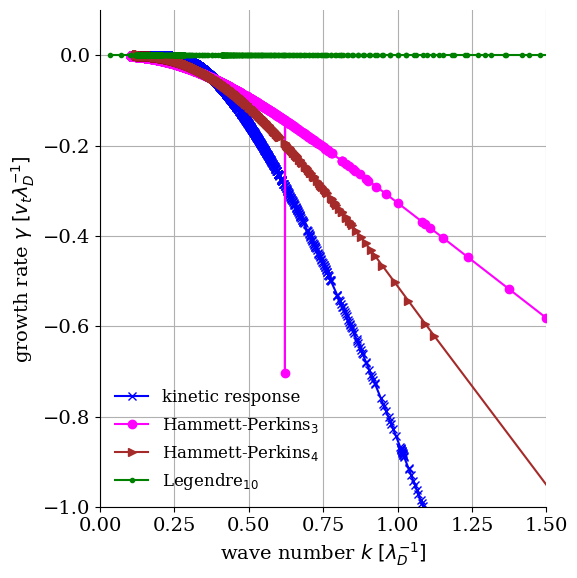

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"Hammett-Perkins$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"Hammett-Perkins$_{4}$", c="brown", marker=">")
ax.plot(k_l10,  gr_l10*np.sqrt(2)*k_l10, label=r"Legendre$_{10}$", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-1, 0.1)
ax.set_xlim(0, 1.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("../figs/landau_damping_hp.png", dpi=600)

# Two-Stream

In [35]:
T = 1/(2*np.sqrt(2))

In [36]:
# Despersion relation
def disp_k_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*R(xi=((xi-u2)/T))/(T**2) - (1-n1)*R(xi=((xi-u1)/T))/(T**2)

# Despersion relation
def disp_k_hp3_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*RHP3(xi=(xi-u2)/T)/(T**2) - (1-n1)*RHP3(xi=(xi-u1)/T)/(T**2)

# Despersion relation
def disp_k_hp4_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*RHP4(xi=(xi-u2)/T)/(T**2) -(1-n1)*RHP4(xi=(xi-u1)/T)/(T**2)

# Despersion relation
def disp_k_10_bot(xi, n1=0.5, u1=0, u2=2, T=T):
    return -n1*R10(xi=(xi-u2)/T)/(T**2) + -(1-n1)*R10(xi=(xi-u1)/T)/(T**2)

In [47]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(1E-2, 4, int(1e4)), xi_imag=np.linspace(0.001, 3, int(1e4)), tol=1e-4)

In [38]:
gr_hp3, k_hp3 = get_landau_dispersion(func=disp_k_hp3_bot, xi_real=np.linspace(0, 4, int(1e4)), xi_imag=np.linspace(0.001, 3, int(1e4)), tol=1e-4)

In [39]:
gr_hp4, k_hp4 = get_landau_dispersion(func=disp_k_hp4_bot, xi_real=np.linspace(0, 4, int(1e4)), xi_imag=np.linspace(0.001, 3, int(1e4)), tol=1e-4)

In [40]:
gr_l10, k_l10 = get_landau_dispersion(func=disp_k_10_bot, xi_real=np.linspace(0, 4, int(1e3)), xi_imag=np.linspace(0, 3, int(1e3)), tol=1e-3)

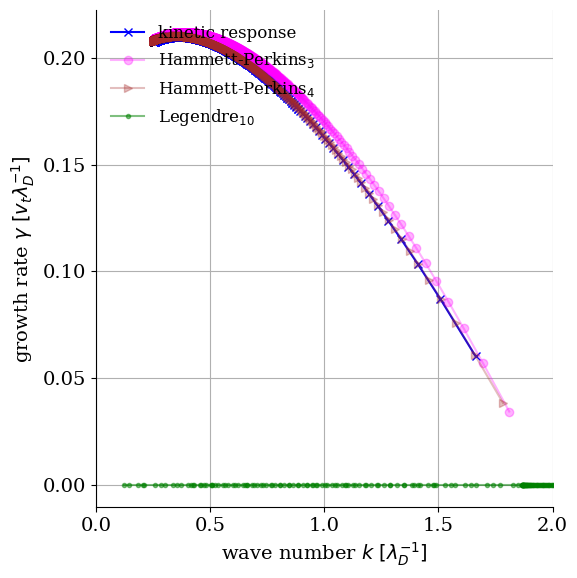

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true*T, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3*T, label=r"Hammett-Perkins$_{3}$", c="magenta", marker="o", alpha=0.3)
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4*T, label=r"Hammett-Perkins$_{4}$", c="brown", marker=">", alpha=0.3)
ax.plot(k_l10,  gr_l10*np.sqrt(2)*k_l10*T, label=r"Legendre$_{10}$", c="green", marker=".", alpha=0.5)

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
#ax.set_ylim(-1, 0.1)
ax.set_xlim(0., 2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("../figs/bump_on_tail_hp.png", dpi=600)

In [42]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(0, 6, int(1e4)), xi_imag=np.linspace(0, -1, int(1e4)), tol=1e-8)

# Bump on tail

In [103]:
# Despersion relation
def disp_k_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R(xi=(xi-u2)) - (1-n1)*R(xi=((xi-u1)/T))

# Despersion relation
def disp_k_hp3_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP3(xi=(xi-u2)) - (1-n1)*RHP3(xi=(xi-u1)/T)

# Despersion relation
def disp_k_hp4_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*RHP4(xi=(xi-u2)) -(1-n1)*RHP4(xi=(xi-u1)/T)

# Despersion relation
def disp_k_10_bot(xi, n1=0.8, u1=0, u2=3, T=1):
    return -n1*R10(xi=(xi-u2)) -(1-n1)*R10(xi=(xi-u1)/T)

In [104]:
gr_true, k_true = get_landau_dispersion(func=disp_k_bot, xi_real=np.linspace(1E-2, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [105]:
gr_hp3, k_hp3 = get_landau_dispersion(func=disp_k_hp3_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [106]:
gr_hp4, k_hp4 = get_landau_dispersion(func=disp_k_hp4_bot, xi_real=np.linspace(0, 2, int(1e4)), xi_imag=np.linspace(0.001, 1, int(1e4)), tol=1e-6)

In [107]:
gr_l10, k_l10 = get_landau_dispersion(func=disp_k_10_bot, xi_real=np.linspace(0, 4, int(1e3)), xi_imag=np.linspace(0, 3, int(1e3)), tol=1e-3)

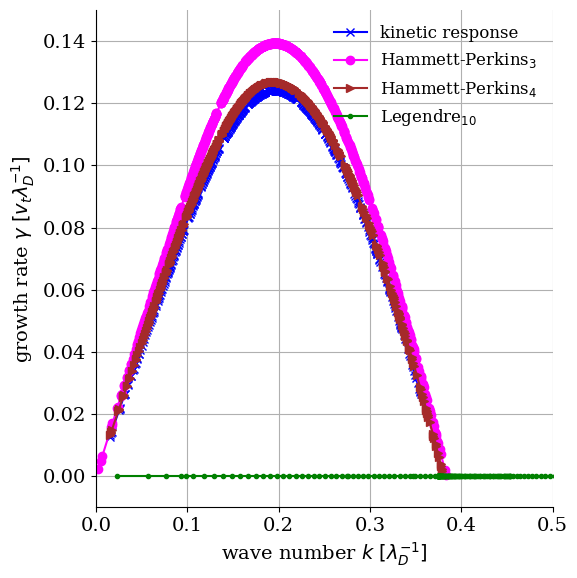

In [110]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(k_true, gr_true*np.sqrt(2)*k_true, label=r"kinetic response", c="blue", marker="x")
ax.plot(k_hp3,  gr_hp3*np.sqrt(2)*k_hp3, label=r"Hammett-Perkins$_{3}$", c="magenta", marker="o")
ax.plot(k_hp4,  gr_hp4*np.sqrt(2)*k_hp4, label=r"Hammett-Perkins$_{4}$", c="brown", marker=">")
ax.plot(k_l10,  gr_l10*np.sqrt(2)*k_l10, label=r"Legendre$_{10}$", c="green", marker=".")

ax.set_ylabel(r"growth rate $\gamma$ $[v_{t}\lambda_{D}^{-1}]$")
ax.set_xlabel(r"wave number $k$ $[\lambda_{D}^{-1}]$")
ax.set_ylim(-0.01, 0.15)
ax.set_xlim(0., 0.5)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig("../figs/bump_on_tail_hp.png", dpi=600)